In [ ]:
!git clone https://github.com/kr-viku/GLAUCOMA-DETECTION

Cloning into 'GLAUCOMA-DETECTION'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 563 (delta 32), reused 97 (delta 31), pack-reused 465
Receiving objects: 100% (563/563), 61.73 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (567/567), done.


Epoch 1/5
15/15 [==============================] - 45s 3s/step - loss: 1.4374 - accuracy: 0.5846 - val_loss: 0.6222 - val_accuracy: 0.6094
Epoch 2/5
15/15 [==============================] - 38s 2s/step - loss: 0.5453 - accuracy: 0.7275 - val_loss: 0.6206 - val_accuracy: 0.6562
Epoch 3/5
15/15 [==============================] - 41s 3s/step - loss: 0.5014 - accuracy: 0.7516 - val_loss: 0.5209 - val_accuracy: 0.7031
Epoch 4/5
15/15 [==============================] - 39s 3s/step - loss: 0.4370 - accuracy: 0.8022 - val_loss: 0.4673 - val_accuracy: 0.7500
Epoch 5/5
2/2 [==============================] - 1s 617ms/step - loss: 0.4325 - accuracy: 0.7812
Test Accuracy: 0.78125
Test Loss: 0.43248701095581055


1/1 [==============================] - 1s 678ms/step


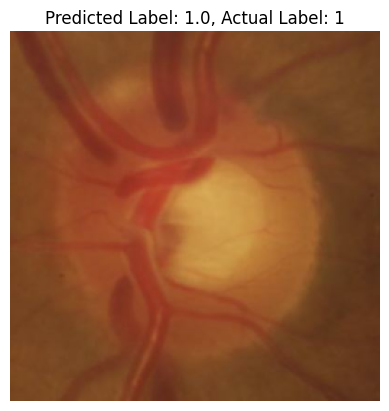

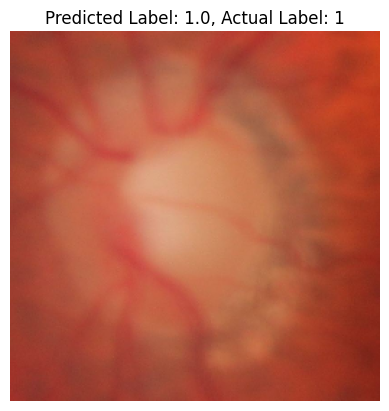

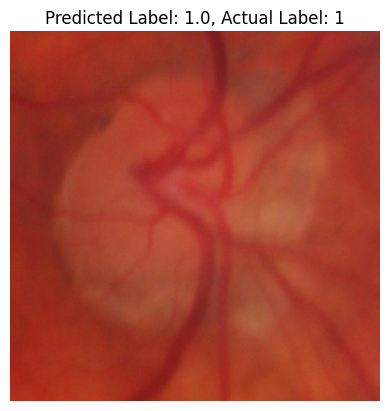

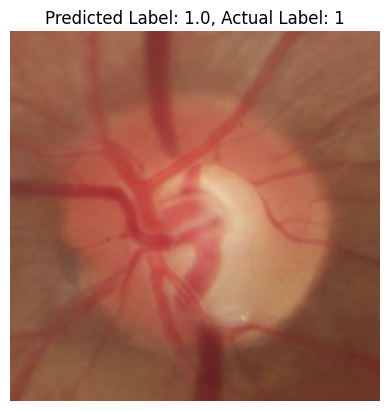

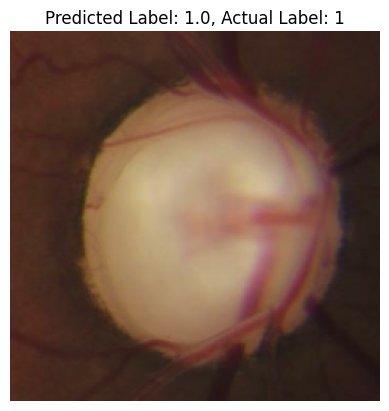

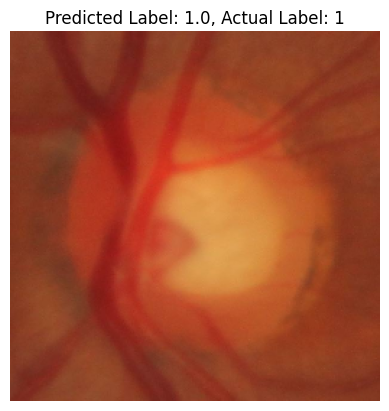

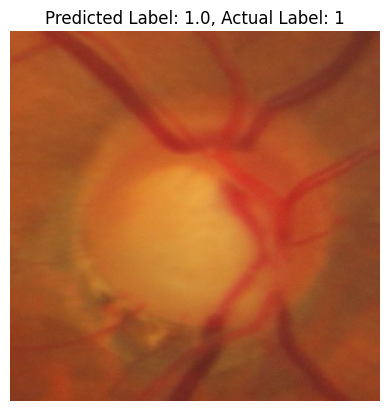

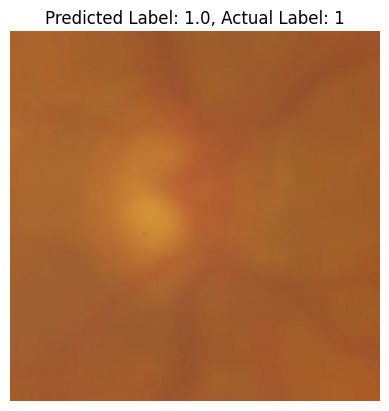

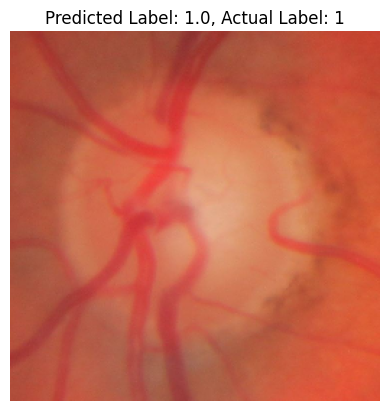

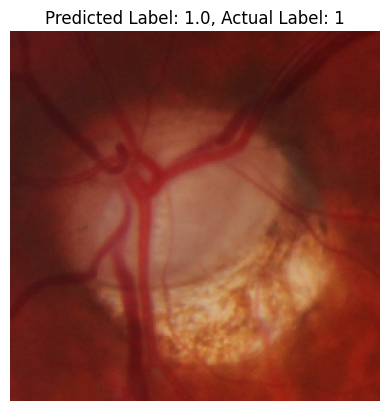

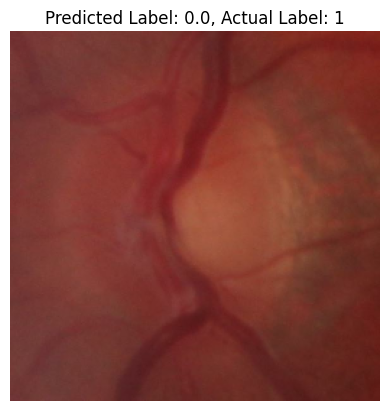

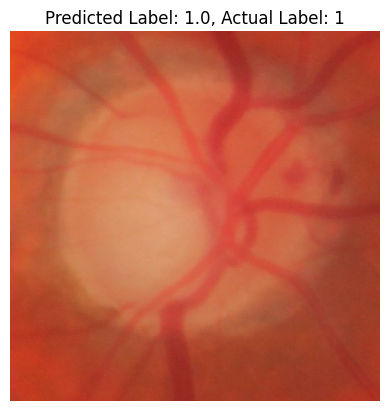

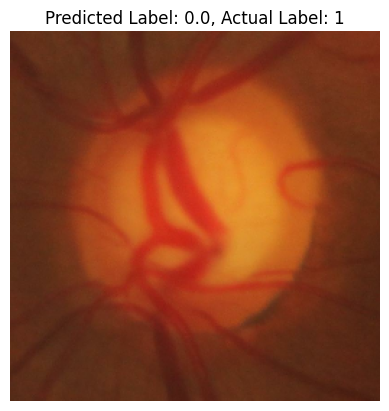

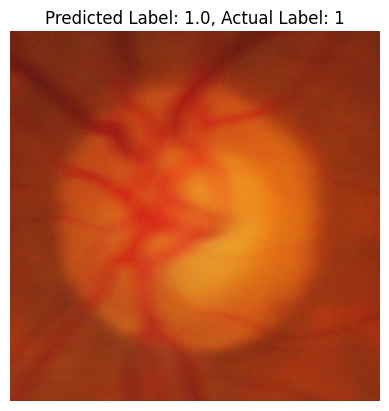

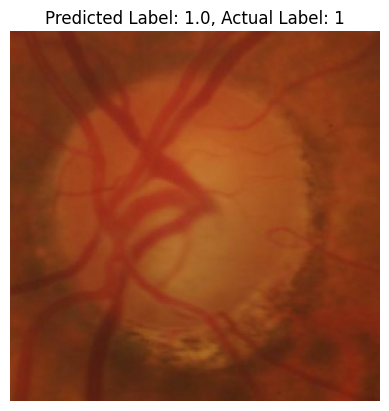

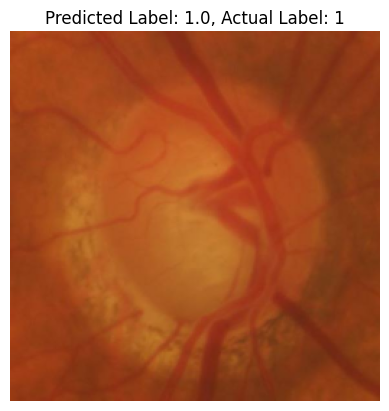

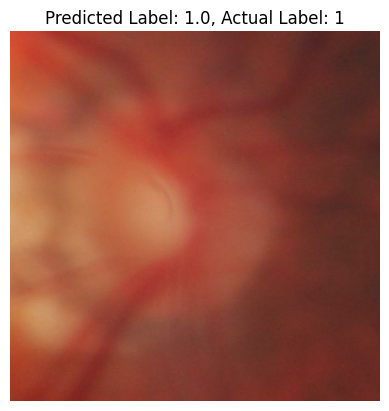

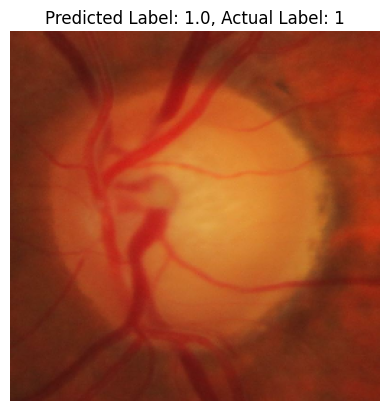

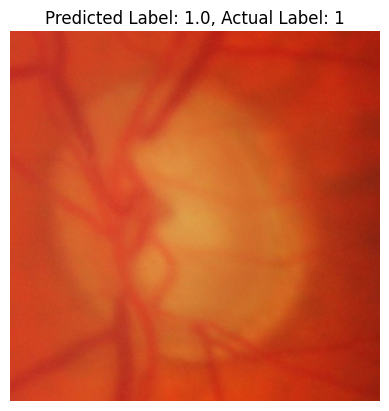

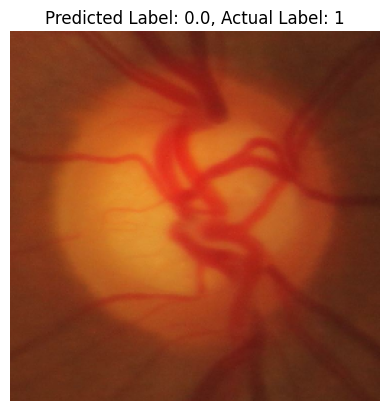

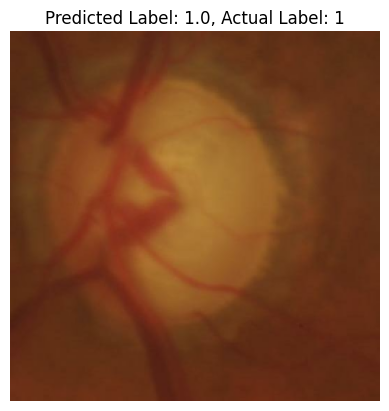

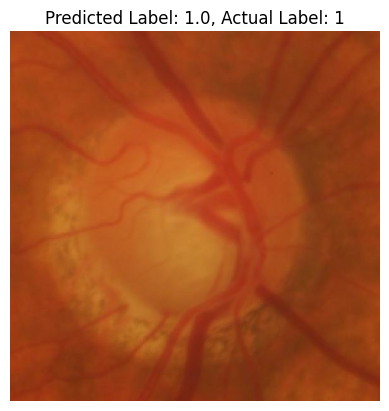

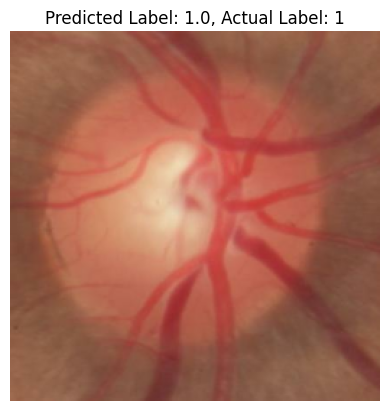

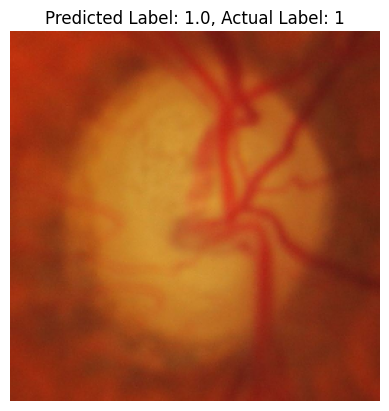

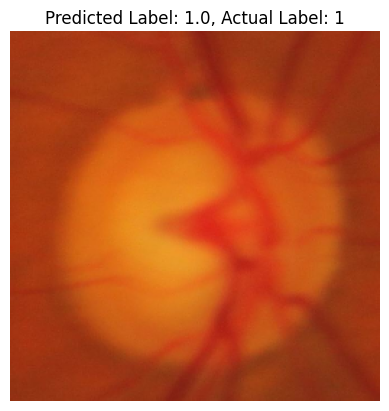

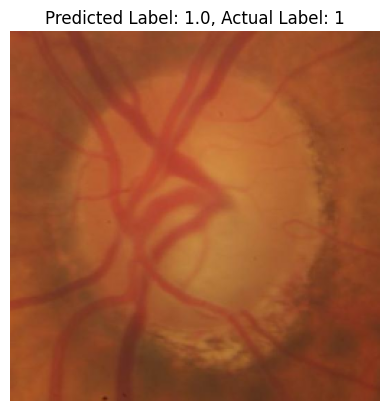

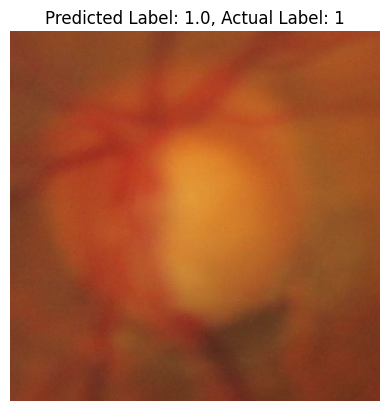

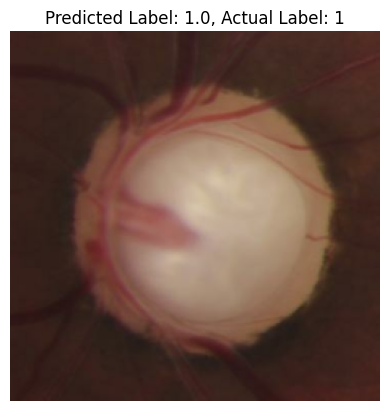

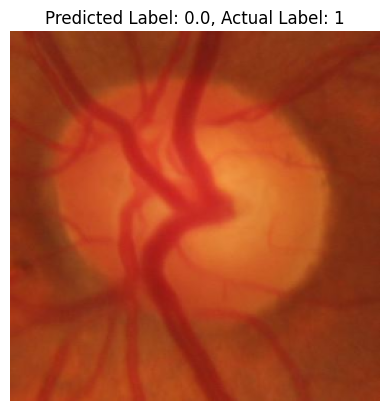

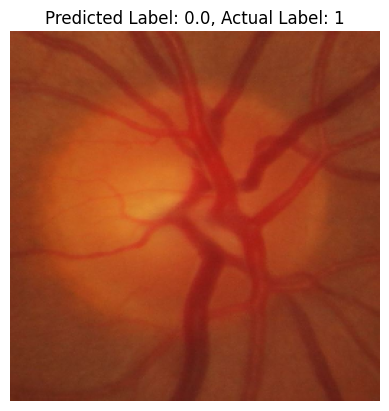

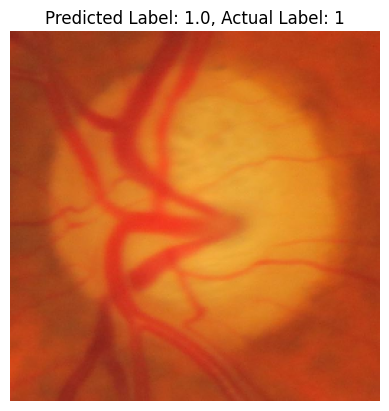

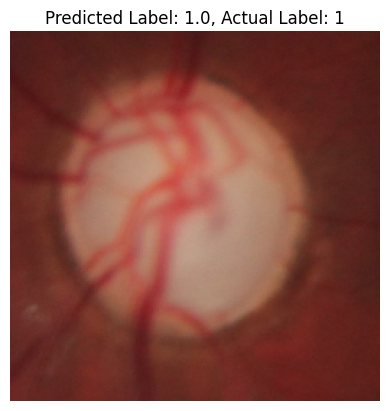

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a function to load and preprocess image files
def preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Define paths to the training and testing data directories
train_data_dir = '/content/GLAUCOMA-DETECTION/dataset/train'
test_data_dir = '/content/GLAUCOMA-DETECTION/dataset/test'

# Map class names to numerical labels
class_to_label = {'class0': 0, 'class1': 1}

# Get a list of all image filenames and their corresponding labels for training data
train_filenames = []
train_labels = []
for class_name in os.listdir(train_data_dir):
    class_dir = os.path.join(train_data_dir, class_name)
    class_label = class_to_label[class_name]
    for fname in os.listdir(class_dir):
        train_filenames.append(os.path.join(class_dir, fname))
        train_labels.append(class_label)

# Get a list of all image filenames and their corresponding labels for testing data
test_filenames = []
test_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    class_label = class_to_label[class_name]
    for fname in os.listdir(class_dir):
        test_filenames.append(os.path.join(class_dir, fname))
        test_labels.append(class_label)

# Create TensorFlow datasets from the image filenames and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))

# Map the preprocess_image function to the datasets
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)

# Fit the model to the training data
model_info = classifier.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = classifier.evaluate(test_dataset)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# Example of making predictions on individual images

# Get a batch of test images and labels
test_images, test_labels = next(iter(test_dataset))

# Make predictions
predictions = classifier.predict(test_images)

# Convert predictions to binary labels (0 or 1)
binary_predictions = np.round(predictions)

# Visualize images with predicted labels
for i in range(len(test_images)):
    plt.imshow(test_images[i])
    plt.axis('off')
    predicted_label = binary_predictions[i][0]
    actual_label = test_labels[i].numpy()
    plt.title(f'Predicted Label: {predicted_label}, Actual Label: {actual_label}')
    plt.show()
